<a href="https://colab.research.google.com/github/Srija0603/Parking_Space_Detection_/blob/main/Parking_Space_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install super-gradients
!pip install --upgrade pillow
!pip install --upgrade torchvision

In [ ]:
import os
import random
import torch
import requests
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)



The console stream is logged into /root/sg_logs/console.log


[2024-11-28 19:06:31] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-11-28 19:06:43] INFO - utils.py - NumExpr defaulting to 2 threads.


In [ ]:
from google.colab import files

# Upload file
uploaded = files.upload()


In [ ]:
import os
import zipfile

# Define the zip file path (replace 'your_file.zip' with your filename)
zip_file_path = "/content/archive.zip"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/your_folder")  # Extract to specified folder


In [ ]:
!ls /content/your_folder

annotations.xml  boxes	images	parking.csv


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import xml.etree.ElementTree as ET
import random
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
path = "/content/your_folder/annotations.xml"

In [ ]:
for anno in glob.glob(path):
    tree = ET.parse(anno)
    root = tree.getroot()
    for image_elem in root.iter("polygon"):
        image_attrs = image_elem.attrib
        points=image_attrs['points']
        break

print(points)
points2=points.split(';')
pts=[]
for p in points2:
    p0p1=p.split(',')
    p0=float(p0p1[0])
    p1=float(p0p1[1])
    pts+=[(p0,p1)]
print(pts)
def points2pts(points):
    points2=points.split(';')
    pts=[]
    for p in points2:
        p0p1=p.split(',')
        p0=float(p0p1[0])
        p1=float(p0p1[1])
        pts+=[(p0,p1)]
    return pts

54.80,9.10;137.90,7.60;141.12,204.87;55.80,205.70
[(54.8, 9.1), (137.9, 7.6), (141.12, 204.87), (55.8, 205.7)]


In [ ]:
dataset = []

for anno in glob.glob(path):
    tree = ET.parse(anno)
    root = tree.getroot()

    for image_elem in root.iter("image"):
        image_attrs = image_elem.attrib
        image_data = {
            "id": str(image_attrs['id']),
            "name": str(image_attrs['name']),
            "width": float(image_attrs['width']),
            "height": float(image_attrs['height']),
            "polygon": []
        }

        for box_elem in image_elem.iter("polygon"):
            box_attrs = box_elem.attrib
            #print(box_attrs)
            box_data = {
                "label": box_attrs['label'],
                #"occluded": int(box_attrs['occluded']),
                "points": str(box_attrs['points']),
            }
            image_data["polygon"].append(box_data)

        dataset.append(image_data)

In [ ]:
data0=pd.DataFrame(dataset)
display(data0)

,id,name,width,height,polygon
0,0,images/0.png,1200.0,621.0,"[{'label': 'free_parking_space', 'points': '54..."
1,1,images/1.png,650.0,487.0,"[{'label': 'not_free_parking_space', 'points':..."
2,2,images/10.png,2560.0,1820.0,"[{'label': 'not_free_parking_space', 'points':..."
3,3,images/11.png,1353.0,1041.0,"[{'label': 'not_free_parking_space', 'points':..."
4,4,images/12.png,1920.0,1080.0,"[{'label': 'free_parking_space', 'points': '90..."
5,5,images/13.png,1280.0,720.0,"[{'label': 'not_free_parking_space', 'points':..."
6,6,images/14.png,1920.0,1080.0,"[{'label': 'not_free_parking_space', 'points':..."
7,7,images/15.png,1100.0,732.0,"[{'label': 'free_parking_space', 'points': '64..."
8,9,images/17.png,768.0,768.0,"[{'label': 'not_free_parking_space', 'points':..."
9,10,images/18.png,897.0,651.0,"[{'label': 'not_free_parking_space', 'points':..."


In [ ]:
data2=pd.DataFrame()
for i in range(len(data0)):
    boxes=data0.loc[i,'polygon']
    a=data0.loc[i,'name']
    b=data0.loc[i,'width']
    c=data0.loc[i,'height']
    for box in boxes:
        d=box['label']
        e=box['points']
        f=points2pts(e)
        add_df=pd.DataFrame([[a,b,c,d,f]])
        data2=pd.concat([data2,add_df],axis=0)

data2.columns=['name','width','height','label','points']
data2=data2.reset_index(drop=True)
display(data2)

,name,width,height,label,points
0,images/0.png,1200.0,621.0,free_parking_space,"[(54.8, 9.1), (137.9, 7.6), (141.12, 204.87), ..."
1,images/0.png,1200.0,621.0,free_parking_space,"[(0.0, 415.4), (52.0, 415.0), (53.91, 607.66),..."
2,images/0.png,1200.0,621.0,free_parking_space,"[(-0.0, 7.58), (52.61, 6.63), (55.83, 203.9), ..."
3,images/0.png,1200.0,621.0,free_parking_space,"[(1109.84, 2.86), (1196.26, 2.62), (1197.67, 1..."
4,images/0.png,1200.0,621.0,free_parking_space,"[(1021.69, 3.21), (1108.11, 2.98), (1109.53, 1..."
...,...,...,...,...,...
898,images/9.png,1920.0,1084.0,free_parking_space,"[(362.34, 693.78), (499.1, 646.51), (570.02, 8..."
899,images/9.png,1920.0,1084.0,not_free_parking_space,"[(510.92, 646.51), (654.44, 599.23), (737.18, ..."
900,images/9.png,1920.0,1084.0,not_free_parking_space,"[(664.57, 595.35), (803.03, 548.07), (884.07, ..."
901,images/9.png,1920.0,1084.0,free_parking_space,"[(811.5, 543.5), (934.73, 506.36), (1029.28, 7..."


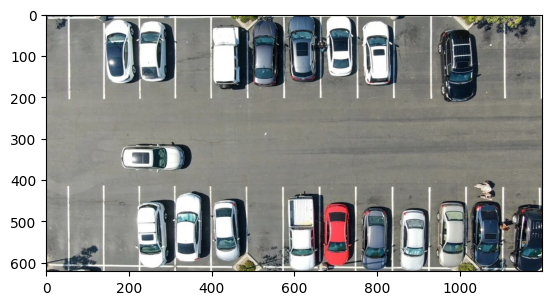

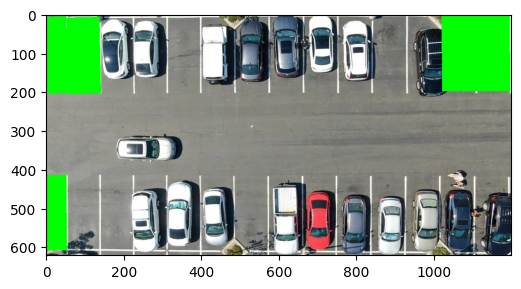

In [ ]:
path1='/content/your_folder/images/0.png'
img = cv2.imread(path1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

for i in range(5):
    mask = data2.loc[i,'points']
    mask = np.array(mask).reshape((-1,2)).astype(np.int32)
    cv2.fillPoly(img,[mask],(0,255,0))
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img)
plt.show()

In [ ]:
data2['label'].unique().tolist()

['free_parking_space',
 'not_free_parking_space',
 'partially_free_parking_space']

In [ ]:
reverse_mapping={'free_parking_space':0,'not_free_parking_space':1,'partially_free_parking_space':2}

In [ ]:
def calculate_bbox(points):
    x_values, y_values = zip(*points)
    xmin = min(x_values)
    xmax = max(x_values)
    ymin = min(y_values)
    ymax = max(y_values)
    return xmin, xmax, ymin, ymax

data2[['xmin','xmax','ymin','ymax']]=data2['points'].apply(lambda x: pd.Series(calculate_bbox(x)))
data2['label2']=data2['label'].apply(lambda x:reverse_mapping[x])
data2['Xcent']=(data2['xmin']+data2['xmax'])/(2*data2['width'])
data2['Ycent']=(data2['ymin']+data2['ymax'])/(2*data2['height'])
data2['boxW']=(data2['xmax']-data2['xmin'])/data2['width']
data2['boxH']=(data2['ymax']-data2['ymin'])/data2['height']


In [ ]:
display(data2)
data2.to_csv('annotation.csv',index=False)

,name,width,height,label,points,xmin,xmax,ymin,ymax,label2,Xcent,Ycent,boxW,boxH
0,images/0.png,1200.0,621.0,free_parking_space,"[(54.8, 9.1), (137.9, 7.6), (141.12, 204.87), ...",54.80,141.12,7.60,205.70,0,0.081633,0.171739,0.071933,0.319002
1,images/0.png,1200.0,621.0,free_parking_space,"[(0.0, 415.4), (52.0, 415.0), (53.91, 607.66),...",0.00,53.91,415.00,608.18,0,0.022462,0.823816,0.044925,0.311079
2,images/0.png,1200.0,621.0,free_parking_space,"[(-0.0, 7.58), (52.61, 6.63), (55.83, 203.9), ...",-0.00,55.83,6.63,204.44,0,0.023262,0.169944,0.046525,0.318535
3,images/0.png,1200.0,621.0,free_parking_space,"[(1109.84, 2.86), (1196.26, 2.62), (1197.67, 1...",1109.84,1197.67,2.62,198.59,0,0.961463,0.162005,0.073192,0.315572
4,images/0.png,1200.0,621.0,free_parking_space,"[(1021.69, 3.21), (1108.11, 2.98), (1109.53, 1...",1021.69,1109.53,2.98,198.95,0,0.888008,0.162585,0.073200,0.315572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,images/9.png,1920.0,1084.0,free_parking_space,"[(362.34, 693.78), (499.1, 646.51), (570.02, 8...",362.34,570.02,646.51,911.60,0,0.242802,0.718685,0.108167,0.244548
899,images/9.png,1920.0,1084.0,not_free_parking_space,"[(510.92, 646.51), (654.44, 599.23), (737.18, ...",510.92,737.18,599.23,867.70,1,0.325026,0.676628,0.117844,0.247666
900,images/9.png,1920.0,1084.0,not_free_parking_space,"[(664.57, 595.35), (803.03, 548.07), (884.07, ...",664.57,884.07,548.07,806.40,1,0.403292,0.624756,0.114323,0.238312
901,images/9.png,1920.0,1084.0,free_parking_space,"[(811.5, 543.5), (934.73, 506.36), (1029.28, 7...",811.50,1029.28,506.36,749.50,0,0.479370,0.579271,0.113427,0.224299


In [ ]:
!mkdir labels

In [ ]:
files=data2['name'].unique().tolist()
for file in files:
    datai=data2[data2['name']==file].iloc[:,9:]
    #display(datai)
    name=file.split('/')[-1][0:-4]
    fmt = ['%d'] + ['%f'] * (datai.shape[1]-1)
    np.savetxt("labels/"+name+".txt", np.array(datai), fmt=fmt, delimiter="\t")

In [ ]:

path0 = '/content/your_folder/images'
path0l = '/content/labels'
path1a = '/content/data/train/images'
path1b = '/content/data/val/images'
path1c = '/content/data/test/images'
path1al = '/content/data/train/labels'
path1bl = '/content/data/val/labels'
path1cl = '/content/data/test/labels'

os.makedirs(path0l, exist_ok=True)
os.makedirs(path1a, exist_ok=True)
os.makedirs(path1b, exist_ok=True)
os.makedirs(path1c, exist_ok=True)
os.makedirs(path1al, exist_ok=True)
os.makedirs(path1bl, exist_ok=True)
os.makedirs(path1cl, exist_ok=True)

# ... (rest of your code)

paths0 = glob.glob(os.path.join(path0, "*.png")) # Assuming png images
for i,path in enumerate(paths0):
    if i<16:
        !cp -r {path} {path1a}
        file=path.split('/')[-1][0:-4]+'.txt'
        path2=os.path.join(path0l,file)
        if os.path.exists(path2): #Check if the label file exists
          !cp -r {path2} {path1al}
        else:
          print(f"Label file not found for {path}, skipping copy")
    elif i<24:
        !cp -r {path} {path1b}
        file=path.split('/')[-1][0:-4]+'.txt'
        path2=os.path.join(path0l,file)
        if os.path.exists(path2):
          !cp -r {path2} {path1bl}
        else:
          print(f"Label file not found for {path}, skipping copy")
    else:
        !cp -r {path} {path1c}
        file=path.split('/')[-1][0:-4]+'.txt'
        path2=os.path.join(path0l,file)
        if os.path.exists(path2):
          !cp -r {path2} {path1cl}
        else:
          print(f"Label file not found for {path}, skipping copy")

In [ ]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'race_number' #specify the experiment name
    #dataset params
    DATA_DIR = '/content/data' #parent directory to where data lives
    TRAIN_IMAGES_DIR = '/content/data/train' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = '/content/data/train/labels' #child dir of DATA_DIR where train labels are
    VAL_IMAGES_DIR = '/content/data/val' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR ='/content/data/val/labels'  #child dir of DATA_DIR where validation labels are
    # if you have a test set
    TEST_IMAGES_DIR = '/content/data/test' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = '/content/data/test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['free_parking_space','not_free_parking_space','partially_free_parking_space']
    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size': 4,
    'num_workers': 2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco


In [ ]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'race_number' #specify the experiment name
    #dataset params
    DATA_DIR = '/content/data' #parent directory to where data lives
    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are
    VAL_IMAGES_DIR = 'val/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR ='val/labels'  #child dir of DATA_DIR where validation labels are
    # if you have a test set
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['free_parking_space','not_free_parking_space','partially_free_parking_space']
    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size': 4,
    'num_workers': 2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

In [ ]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME,
                  ckpt_root_dir=config.CHECKPOINT_DIR)

In [ ]:
import os

if not os.path.exists(os.path.join(config.DATA_DIR, config.TRAIN_IMAGES_DIR)):
    print(f"Error: Directory not found: {os.path.join(config.DATA_DIR, config.TRAIN_IMAGES_DIR)}")
else:
    print(f"Directory found: {os.path.join(config.DATA_DIR, config.TRAIN_IMAGES_DIR)}")

Directory found: /content/data/train/images


In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2024-11-28 19:21:05] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 16/16 [00:00<00:00, 3266.43it/s]
[2024-11-28 19:21:05] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 8/8 [00:00<00:00, 1048.18it/s]
[2024-11-28 19:21:05] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 6/6 [00:00<00:00, 2343.84it/s]


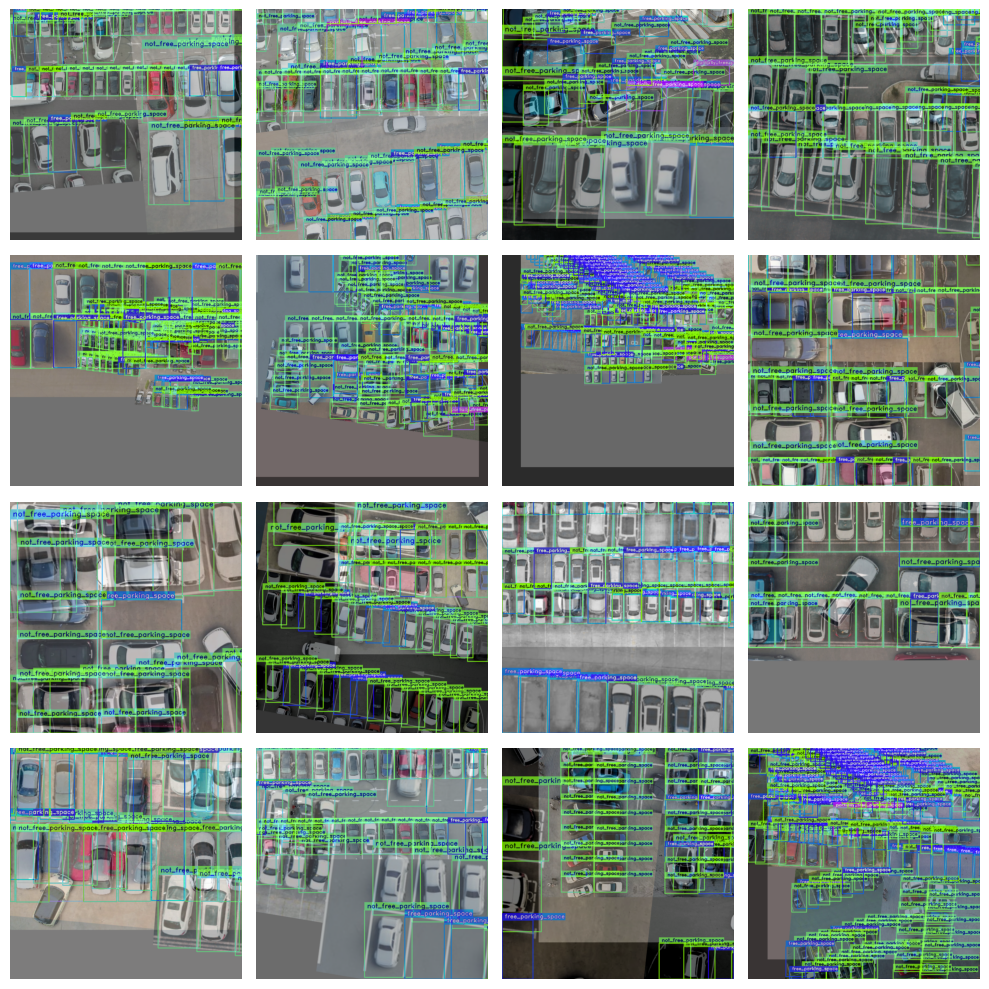

In [ ]:
train_data.dataset.plot()

In [ ]:
!ping <domain_name_of_url>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `ping <domain_name_of_url>'


In [ ]:
from super_gradients.training import models

In [ ]:
from ultralytics import YOLO

# Load YOLO model
model = YOLO("yolov8n.pt")

# Detect objects in PASCAL VOC
results = model("/content/rose.ipt.jpg")

# Plotting results
results[0].plot()
